In [1]:
%matplotlib widget
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns
sns.set()

import torch
from torch import nn
from torch.nn import functional as F
from torch.distributions import Normal, MultivariateNormal

## Neural Processes++

#### Masked sinsuoids

In [2]:
import numpy as np
from torch.utils.data import Dataset

def gen_sinusoid(x,y,t):
    """
    generate a sinusoid for a period x and phase y
    Args:
        x (float): period
        y (float): phase
        t (list): time vector
    Returns:
        sinusoid (np.array): image of t by the function t |----> 0.5 + 0.5 * sin(pi t x + pi y)
    """
    return np.asarray([ 0.5 + 0.499 *np.sin(3.14 *u * x  + 3.14 * y) for u in t]) 

class Sinusoids(Dataset):
    """
    A simple dataset for time-series modeling compatible with PyTorch torch.utils.data.Loader object
    
    Generate sinuoids with random phases and peridos
    """

    def __init__(self,num_steps,n_phases=1,virtual_size=1000, quantization=-1):
        """
        
        Args:
            num_steps (int): number of steps for each item
            virtual_size (int): virtual size for the dataset
            quantization (int): if > 0, quantize the output into the range [0,'quantization']
        """
            
        self.t = np.linspace(-n_phases,n_phases,num_steps)
        self.virtual_size = virtual_size
        self.quantization = quantization

    def __len__(self):
        return self.virtual_size

    def __getitem__(self, idx):
        z_1 = np.random.uniform(-1,1)
        z_2 = np.random.uniform(-1,1)
        data = np.expand_dims( gen_sinusoid(z_1,z_2,self.t) , 1)
        if self.quantization > 0:
            data = (self.quantization*data).astype(int)
        return data

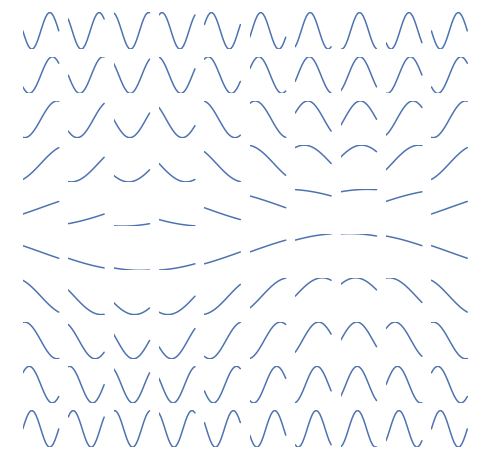

In [5]:
t = np.linspace(-1,1,20)
fig = plt.figure()
fig.set_figheight(8)
fig.set_figwidth(8)
i = 1
n = 10
for xx in np.linspace(-1,1,n):
    for yy in np.linspace(-1,1,n):
        X = gen_sinusoid(xx,yy,t)
        ax1 = fig.add_subplot(n,n,i)
        ax1.plot(X)
        ax1.set_xlim([0,20])
        ax1.set_ylim([0,1])
        #ax1.axis('equal')
        ax1.axis('off')
        i+=1 
plt.show() 

#### Implement posterior loglikelihood

In [90]:
prior_alpha = Normal(0,1)
prior_beta = Normal(0,1)
mu = lambda h, mu_a, mu_b :  h @ mu_a.t() + mu_b
sigma2 = lambda h, sigma_a, sigma_b: (h @ sigma_a.t())**2 + sigma_b**2
def log_ll(y, mu, sigma_2):
    return -0.5 * ( torch.log(sigma_2) + (y - mu)**2 / sigma_2)
#log_posterior = lambda y, mu, sigma_2 : log_ll(y, mu, sigma_2)

#### Features Extractor, Prior parameters and loss function

In [91]:
class FeaturesExtractor(nn.Module):
    def __init__(self, h):
        super().__init__()
        self.layers = nn.Sequential( nn.Linear(2, 128), nn.ReLU(), nn.Linear(128, h) )
    def forward(self, x):
        return self.layers(x)
    
class Priors(nn.Module):
    def __init__(self, h):
        super().__init__()
        self.mu_a = nn.Parameter(torch.zeros((1,h)))
        self.mu_b = nn.Parameter(torch.tensor(0.))
        self.sigma_a = nn.Parameter(torch.ones((1,h)))
        self.sigma_b = nn.Parameter(torch.tensor(1.))

    def posterior(self, h):
        mu_ = mu(h, self.mu_a, self.mu_b)
        sigma2_ = sigma2(h, self.sigma_a, self.sigma_b)
        return Normal(mu_, sigma2_.sqrt())
        
        
def criterion(h, y, priors):
    mu_ = mu(h, priors.mu_a, priors.mu_b)
    sigma2_ = sigma2(h, priors.sigma_a, priors.sigma_b)
    lp = 0#log_prior(y)
    lll = log_ll(y, mu_, sigma2_)
    return - lll - lp

#### Optimize

In [92]:
h = 8
features = FeaturesExtractor(h)
priors = Priors(h)
l_rate = 0.01
epochs = 5000
optimiser = torch.optim.Adam(list(features.parameters()) + list(priors.parameters()), lr = l_rate) 
x = torch.tensor(x, dtype=torch.float)
y = torch.tensor(y, dtype=torch.float)

for epoch in range(epochs):
    epoch +=1
    optimiser.zero_grad()
    h = features.forward(x)
    loss = criterion(h, y, priors)
    loss = loss.mean()
    loss.backward()# back props
    optimiser.step()# update the parameters
    if epoch % 500 == 0:
        print('epoch {}, loss {}'.format(epoch,loss))

epoch 500, loss 0.563273012638092
epoch 1000, loss 0.4493354856967926
epoch 1500, loss -0.16471311450004578
epoch 2000, loss -0.23060795664787292
epoch 2500, loss -0.222028911113739
epoch 3000, loss -0.20289954543113708
epoch 3500, loss -0.2470550537109375
epoch 4000, loss -0.24347878992557526
epoch 4500, loss -0.328593909740448
epoch 5000, loss -0.1834755688905716


<Figure size 864x576 with 0 Axes>

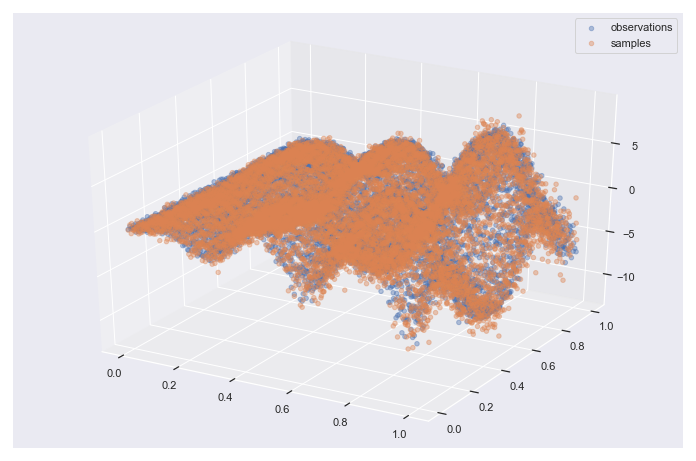

In [93]:
plt.figure(figsize=(12,8))
h = features(x)
p5 = priors.posterior(h).icdf(0.01 * torch.ones_like(priors.mu_b)).detach().numpy()
p95 = priors.posterior(h).icdf(0.99 * torch.ones_like(priors.mu_b)).detach().numpy()
samples = priors.posterior(h).sample().detach().numpy()



fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[:,0], x[:,1], y, alpha=0.4, label='observations')
ax.scatter(x[:,0], x[:,1], samples.squeeze(), alpha=0.4, label='samples')
plt.legend()
plt.show()


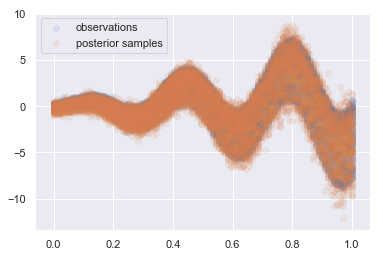

In [97]:
# projection
plt.scatter(x[:, 0],y, alpha=0.1, label='observations')
plt.scatter(x[:, 0],samples, alpha=0.1, label='posterior samples')
#plt.scatter(xx[:, 0],h[:, 0].detach().numpy(), alpha=0.1, label='f(x)')
plt.legend()
plt.show()

In [46]:
p5.max()

tensor(7.9401)